<a href="https://colab.research.google.com/github/AbdoulayeDiop/plant-classification-with-pretrained-ResNet50/blob/main/plant_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# urls = [
#     f"https://www.cvl.isy.liu.se/en/research/datasets/swedish-leaf/leaf{i}.zip" \
#     for i in range(1, 16)
# ]

# with open("urls.txt", "w") as f:
#   for url in urls:
#     f.write(f"{url}\n")

In [4]:
# !mkdir downloads
# !wget -i urls.txt -P downloads/
# !unzip 'downloads/*.zip' -d drive/MyDrive/Datasets/SwedishLeaf/

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
IMG_DIR = "drive/MyDrive/Datasets/SwedishLeaf/"
class_names = {
    1: "Ulmus carpinifolia",
    2: "Acer",
    3: "Salix aurita",
    4: "Quercus",
    5: "Alnus incana",
    6: "Betula pubescens",
    7: "Salix alba - Sericea",
    8: "Populus tremula",
    9: "Ulmus glabra",
    10: "Sorbus aucuparia",
    11: "Salix sinerea",
    12: "Populus",
    13: "Tilia",
    14: "Sorbus intermedia",
    15: "Fagus silvatica"
}

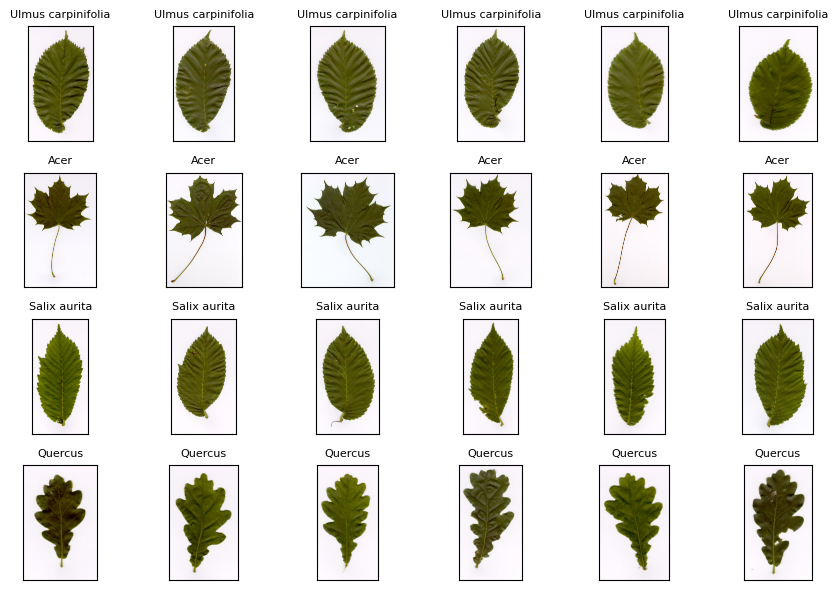

In [6]:
nrows = 4
ncols = 6
plt.figure(figsize=(ncols*1.5, nrows*1.5))
for row in range(nrows):
  leaf_class = row + 1
  class_name = class_names[leaf_class]
  for col in range(ncols):
    plt.subplot(nrows, ncols, row*ncols + col + 1)
    img_number = col + 1
    img = plt.imread(os.path.join(IMG_DIR, f"l{leaf_class}nr{img_number:03d}.tif"))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title(class_name, fontsize=8)
plt.tight_layout()
plt.show()

In [18]:
re.split("[ln]", "l10nr003.tif")

['', '10', 'r003.tif']

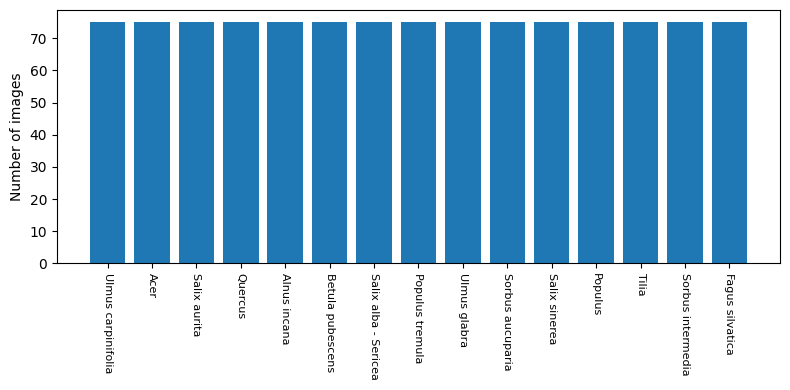

In [24]:
plt.figure(figsize=(8, 4))
all_imgs = os.listdir(IMG_DIR)
class_counts = {i: 0 for i in class_names}
for img_name in all_imgs:
  leaf_class = int(re.split("[ln]", img_name)[1])
  # print(img_name, leaf_class)
  class_counts[leaf_class] += 1

plt.bar(class_names.values(), class_counts.values())
plt.ylabel("Number of images")
plt.xticks(rotation=-90, fontsize=8)
plt.tight_layout()
plt.show()

In [7]:
import torch
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
device

'cuda:0'

In [8]:
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 344MB/s]


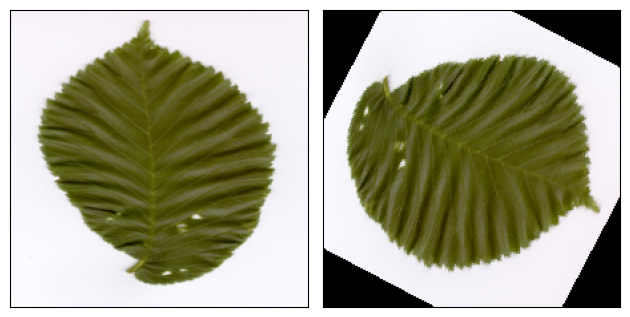

In [32]:
from torchvision import transforms
from PIL import Image

original_img = Image.open(os.path.join(IMG_DIR, f"l1nr003.tif"))
resized_img = transforms.Resize((224, 224))(original_img)
transformed_img = transforms.RandomRotation(180)(resized_img)
imgs = [resized_img, transformed_img]

nrows = 1
ncols = len(imgs)
for col, img in enumerate(imgs):
  plt.subplot(nrows, ncols, col + 1)
  plt.imshow(np.asarray(img))
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()
plt.show()

In [9]:
def finetune(model, ):


<bound method Module.state_dict of Linear(in_features=2048, out_features=1000, bias=True)>